## RawNet2
### Key Components 
- Fixed Sinc Filters (Conv + MaxPooling + BatchNorm + LeakyReLU)
- Residual Blocks with convolutional layers, batch normalization, LeakyReLU, and MaxPooling
- GRU layer with 1024 units
- Fully Connected (FC) Layer for the final output

# Process Original Dataset 

In [1]:
import os
import torch
import numpy as np
import torchaudio
import pandas as pd
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Define the pad function to ensure fixed input size
def pad(x, max_len=64600):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    # Need to pad
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (1, num_repeats))[:, :max_len][0]
    return padded_x

# Define a custom dataset for loading your audio files and labels
class AudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the meta CSV file containing labels
        self.meta_data = pd.read_csv(meta_file)

        # Create a dictionary of filenames to labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))
        
        # Get the list of audio files in the directory
        self.audio_files = [f for f in os.listdir(audio_dir) if f in self.audio_labels]  # Only files with labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the filename and corresponding label
        audio_filename = self.audio_files[idx]
        label = self.audio_labels[audio_filename]
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to a numerical format: 0 for 'spoof', 1 for 'bona-fide'
        label = 1 if label == 'spoof' else 0

        return waveform, label

# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])

### Load original data


In [2]:
# Path to the directory containing the audio files and the CSV file
train_audio_dir = 'ProjectStorage/wav_train_set'
val_audio_dir = 'ProjectStorage/wav_val_set'
test_audio_dir = 'ProjectStorage/wav_test_set'

meta_file = 'ProjectStorage/meta.csv'

# Initialize the dataset with labels
train_dataset = AudioDataset(audio_dir=train_audio_dir, meta_file=meta_file, transform=audio_transforms)
val_dataset = AudioDataset(audio_dir=val_audio_dir, meta_file=meta_file, transform=audio_transforms)
test_dataset = AudioDataset(audio_dir=test_audio_dir, meta_file=meta_file, transform=audio_transforms)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
for i, (inputs, labels) in enumerate(train_loader):
    print(inputs)
    if i == 2:  # Stop after the first three batches
        break


tensor([[ 2.2977e-04, -1.0168e-03, -1.7569e-03,  ..., -8.6255e-03,
         -8.4496e-03, -8.9714e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5092e-02,
         -1.6472e-02, -1.6910e-02],
        [-7.6621e-04, -3.5724e-04,  2.0441e-04,  ...,  1.3550e-02,
          2.1489e-04, -9.7779e-03],
        ...,
        [ 1.6569e-03,  1.6380e-03,  1.4833e-03,  ...,  6.6108e-03,
          7.6473e-03,  5.4739e-03],
        [ 4.0209e-04, -1.7259e-05,  4.5179e-04,  ..., -5.6140e-03,
         -5.0609e-02, -8.9475e-02],
        [ 1.6294e-03,  1.5170e-03,  1.3314e-03,  ..., -1.6122e-02,
         -1.9738e-02, -2.3919e-02]])
tensor([[-5.0345e-05, -3.3484e-04, -6.3815e-04,  ..., -2.7397e-03,
         -1.7549e-03, -1.3077e-03],
        [-3.0598e-04, -3.9913e-04, -2.5249e-04,  ..., -3.9762e-02,
         -3.6322e-02, -3.1985e-02],
        [ 1.6013e-03,  4.3594e-03,  3.3389e-03,  ..., -1.9396e-02,
         -1.9701e-02, -2.1196e-02],
        ...,
        [-1.5044e-04, -1.1886e-04, -1.2346e-05


# RawNet2 Architecture 

#### Working Features:

SincConv Layer:
- To convert the raw audio input into learnable filters, which are defined in the frequency domain.
You're using Mel scale conversion effectively to initialize the filter banks.

Residual Blocks:
- hese blocks provide skip connections, preventing vanishing gradient issues in deep networks. You have both convolution and downsampling layers to adjust the dimensions.

Attention Mechanism:
- The attention mechanism implemented using fully connected layers (fc_attention) helps focus on important parts of the input sequence.
- The application of sigmoid activation is effective for learning the attention weights.


GRU Layer:
- GRU layers are effective for sequence learning, making them a great choice for temporal data such as audio.
You use a multi-layer GRU and batch normalization for stability and performance.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np


class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, device, out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):
        super(SincConv, self).__init__()

        if in_channels != 1:
            msg = "SincConv only supports one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate  # Higher sample rates can capture more detail but require more computational power.

        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.device = device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        # initialize filterbanks using Mel scale
        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)   # Hz to mel conversion
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2, (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)

    def forward(self, x): # this method defines the forward pass of the SincConv layer 
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i] # min frequency for each band-pass filter, set the smallest and largest frequencies that the filters will listen to
            fmax = self.mel[i + 1] # max freq
            hHigh = (2 * fmax / self.sample_rate) * np.sinc(2 * fmax * self.hsupp / self.sample_rate)
            hLow = (2 * fmin / self.sample_rate) * np.sinc(2 * fmin * self.hsupp / self.sample_rate)
            hideal = hHigh - hLow
            
            self.band_pass[i, :] = Tensor(np.hamming(self.kernel_size)) * Tensor(hideal) # Hamming window smooths the filters so they don’t have sharp edges, making the model perform better.

        band_pass_filter = self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)


class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False):
        super(Residual_block, self).__init__()
        self.first = first # indicates whether it is the first block in the model, which skips BN
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=3,
                               padding=1,
                               stride=1)

        self.bn2 = nn.BatchNorm1d(num_features=nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               padding=1,
                               kernel_size=3,
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels=nb_filts[0],
                                              out_channels=nb_filts[1],
                                              padding=0,
                                              kernel_size=1,
                                              stride=1)
        else:
            self.downsample = False

        self.mp = nn.MaxPool1d(3)

    def forward(self, x): # Adds the input (identity) to the output of the convolutional layers
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()

        self.device = device

        self.Sinc_conv = SincConv(device=self.device,
                                   out_channels=d_args['filts'][0],
                                   kernel_size=d_args['first_conv'],
                                   in_channels=d_args['in_channels']
                                   )

        self.first_bn = nn.BatchNorm1d(num_features=d_args['filts'][0])
        self.selu = nn.SELU(inplace=True) # Scaled Exponential Linear Unit (activation function)
        # Next, sequential blocks of residual layers, which consist of convolutional layers with skip connections to prevent vanishing gradients
        self.block0 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], first=True)) #[20,20]
        self.block1 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1])) #[20,20]
        self.block2 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[20,128]
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block4 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block5 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.avgpool = nn.AdaptiveAvgPool1d(1) # Average over time, create a summary of the feature map

        # Attention FC layers compute attention weights for each residual block. Highlight important parts of the feature maps
        self.fc_attention0 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features=d_args['filts'][2][-1])
        
        self.gru = nn.GRU(input_size=d_args['filts'][2][-1],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1_gru = nn.Linear(in_features=d_args['gru_node'],
                                  out_features=d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features=d_args['nb_fc_node'],
                                  out_features=d_args['nb_classes'], bias=True)

        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x = x.view(nb_samp, 1, len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)  # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1)  # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1  # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)  # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2  # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1)  # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3  # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)  # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4  # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1)  # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5  # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)

        x = x.transpose(1, 2)
        x, _ = self.gru(x)  # return only hidden states of last layer
        x = x[:, -1, :]  # (batch, seq_len, hidden_size)

        x = self.fc1_gru(x)
        x = self.fc2_gru(x)
        x = self.logsoftmax(x)

        return x

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
                    out_features = l_out_features))
        return nn.Sequential(*l_fc)
    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
                first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)


In [2]:

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("GPU is not available. Running on CPU.")

GPU is available!
GPU name: Tesla V100-SXM2-16GB
Number of GPUs: 4
Current device: 0


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_args = {
    'in_channels': 1,          # For mono audio; set to 2 for stereo
    'first_conv': 1024,         # Adjust this based on your audio length
    'filts': [20, [20,20], [20,128],[128,128]],  # These can be adjusted
    'blocks': [2,4],
    'gru_node': 1024,           # Number of GRU units
    'nb_gru_layer': 3,         # Number of GRU layers
    'nb_fc_node': 1024,         # Number of units in the fully connected layer
    'nb_classes': 2           # Change this to the number of classes in your dataset
}

model = RawNet(d_args, device).to(device)


In [15]:
d_args['filts']

[20, [20, 20], [128, 128], [128, 128]]

# Model Evaluation Function

In [3]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` is your trained RawNet model and `test_loader` is your DataLoader for the test set
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track performance metrics
    all_labels = []
    all_predictions = []
    all_probs = []  # For ROC-AUC or EER if needed
    
    # Disable gradient computation
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device (GPU/CPU)
            data, labels = data.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(data)
            
            # Get the predicted class (highest score in the output)
            _, predicted = torch.max(outputs, dim=1)
            
            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            # Store probabilities for ROC-AUC/EER if needed
            probs = torch.softmax(outputs, dim=1)  # Probability distribution
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            
    # Convert lists to numpy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate Accuracy
    accuracy = np.mean(all_predictions == all_labels) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Calculate Precision, Recall, and F1-Score (binary or multi-class)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # ROC-AUC (for binary classification)
    if len(np.unique(all_labels)) == 2:  # Only for binary classification
        auc_roc = roc_auc_score(all_labels, all_probs)
        print(f"AUC-ROC: {auc_roc:.2f}")
        
        # Optionally, plot the ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
        
        # Calculate EER
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        fnr = 1 - tpr  # False Negative Rate
        eer_index = np.nanargmin(np.abs(fnr - fpr))  # Find index where FNR = FPR
        eer = fpr[eer_index]  # EER value
        eer_threshold = thresholds[eer_index]  # EER threshold
        print(f"EER: {eer:.2f} at threshold: {eer_threshold:.2f}")


# Original data + base architecture
- Cross Entropy Loss 
- introduced early stopping of epochs 

In [6]:
import torch
import torch.optim as optim

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
early_stopping_patience = 3  # Early stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)  # Reduce LR on plateau
best_val_loss = float('inf')



# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage

    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    
    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # You could also save the model here: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs


Epoch [1/10], Average Loss: 0.3151, Accuracy: 87.44%
Validation - Average Loss: 0.3367, Accuracy: 85.65%
Epoch [2/10], Average Loss: 0.1665, Accuracy: 94.58%
Validation - Average Loss: 0.2654, Accuracy: 89.30%
Epoch [3/10], Average Loss: 0.0938, Accuracy: 96.85%
Validation - Average Loss: 0.1064, Accuracy: 96.35%
Epoch [4/10], Average Loss: 0.0871, Accuracy: 97.32%
Validation - Average Loss: 0.0571, Accuracy: 98.36%
Epoch [5/10], Average Loss: 0.0715, Accuracy: 97.68%
Validation - Average Loss: 0.0517, Accuracy: 98.36%
Epoch [6/10], Average Loss: 0.0704, Accuracy: 97.87%
Validation - Average Loss: 1.1371, Accuracy: 73.00%
Epoch [7/10], Average Loss: 0.0596, Accuracy: 98.25%
Validation - Average Loss: 0.0470, Accuracy: 98.62%
Epoch [8/10], Average Loss: 0.0551, Accuracy: 98.26%
Validation - Average Loss: 0.0544, Accuracy: 98.90%
Epoch [9/10], Average Loss: 0.0585, Accuracy: 98.35%
Validation - Average Loss: 0.1628, Accuracy: 92.67%
Epoch [10/10], Average Loss: 0.0415, Accuracy: 98.73%
V

Test Accuracy: 78.67%
Precision: 0.86
Recall: 0.79
F1-Score: 0.79
Confusion Matrix:
[[2694 1347]
 [   9 2306]]
AUC-ROC: 0.99


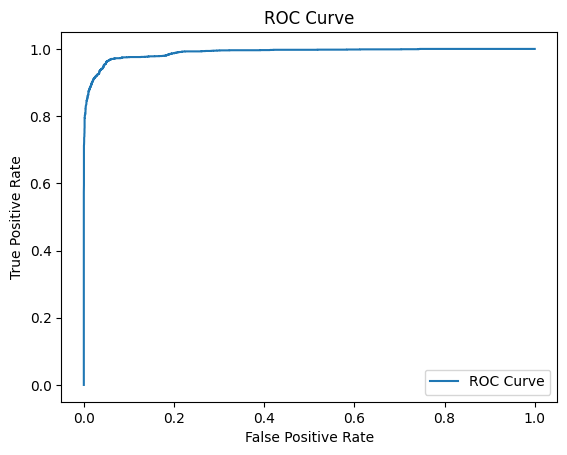

EER: 0.05 at threshold: 1.00


In [7]:
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
torch.save(model, 'oridata_rawnet.pth')

#### Testing robustness of model with external datasets 

In [13]:
import os
import random
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TestAudioDataset(Dataset):
    def __init__(self, bonafide_dir, spoof_dir, num_samples = 3000, transform=None):
        """
        Initialize the dataset with bonafide and spoof directories.
        
        Args:
            bonafide_dir (str): Path to the directory with bonafide audio files.
            spoof_dir (str): Path to the directory with spoofed audio files.
            transform (callable, optional): Optional transform to be applied to the audio data.
        """
        self.bonafide_dir = bonafide_dir
        self.spoof_dir = spoof_dir
        self.transform = transform
        
        # Get a list of bonafide files and spoofed files
        self.bonafide_files = [os.path.join(bonafide_dir, f) for f in os.listdir(bonafide_dir) if f.endswith('.wav')]
        self.spoof_files = [os.path.join(spoof_dir, f) for f in os.listdir(spoof_dir) if f.endswith('.wav')]

        # Randomly sample files
        self.bonafide_files = random.sample(self.bonafide_files, min(num_samples, len(self.bonafide_files)))
        self.spoof_files = random.sample(self.spoof_files, min(num_samples, len(self.spoof_files)))

        # Combine the lists and create labels
        self.audio_files = self.bonafide_files + self.spoof_files
        self.labels = [0] * len(self.bonafide_files) + [1] * len(self.spoof_files)  # 0 for bonafide, 1 for spoof

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        Get a single audio sample and its corresponding label.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            waveform (torch.Tensor): The loaded audio waveform.
            label (int): The label (1 for bonafide, 0 for spoof).
        """
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load the audio waveform
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert waveform to numpy for padding or processing if needed
        waveform = waveform.squeeze().numpy()

        # Apply any transforms if specified
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label
    
# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])




In [8]:
# External dataset distribution 
from collections import Counter

# Function to calculate label distribution
def get_label_distribution(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label)
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    distribution = {k: v / total for k, v in label_counts.items()}
    return label_counts, distribution
# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut"  # Replace with the path to your spoof audio directory

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/jsut_spoof"  # Replace with the path to your spoof audio directory

jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  # Replace with the path to your spoof audio directory

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Calculate label distribution for each dataset
counts, distribution= get_label_distribution(fmcc_dataset )
print("fmcc set size:", len(fmcc_dataset))
print("fmcc set label counts:", counts)
print("fmcc set label distribution:", distribution)

counts, distribution= get_label_distribution(jsut_dataset )

# Print the results
print("jsut_dataset set size:", len(jsut_dataset))
print("jsut_dataset set label counts:", counts)
print("jsut_dataset set label distribution:", distribution)

counts, distribution= get_label_distribution(ljspeech_dataset )

# Print the results
print("ljspeech_dataset set size:", len(ljspeech_dataset))
print("ljspeech_dataset set label counts:", counts)
print("ljspeech_dataset set label distribution:", distribution)



fmcc set size: 6000
fmcc set label counts: Counter({0: 3000, 1: 3000})
fmcc set label distribution: {0: 0.5, 1: 0.5}
jsut_dataset set size: 6000
jsut_dataset set label counts: Counter({0: 3000, 1: 3000})
jsut_dataset set label distribution: {0: 0.5, 1: 0.5}
ljspeech_dataset set size: 6000
ljspeech_dataset set label counts: Counter({0: 3000, 1: 3000})
ljspeech_dataset set label distribution: {0: 0.5, 1: 0.5}


Test Accuracy: 46.00%
Precision: 0.46
Recall: 0.46
F1-Score: 0.46
Confusion Matrix:
[[1224 1776]
 [1464 1536]]
AUC-ROC: 0.43


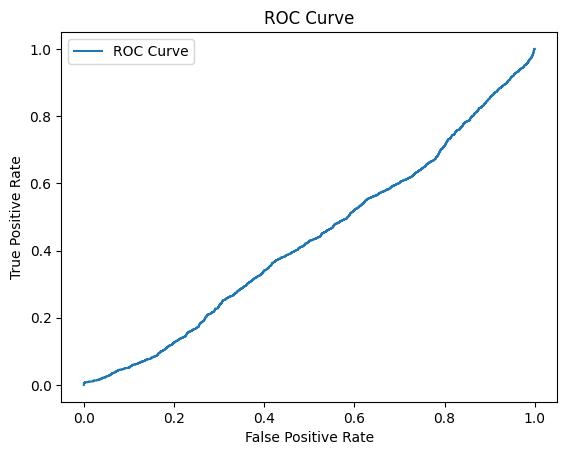

EER: 0.54 at threshold: 0.67
Test Accuracy: 26.80%
Precision: 0.18
Recall: 0.27
F1-Score: 0.21
Confusion Matrix:
[[   2 2998]
 [1394 1606]]
AUC-ROC: 0.02


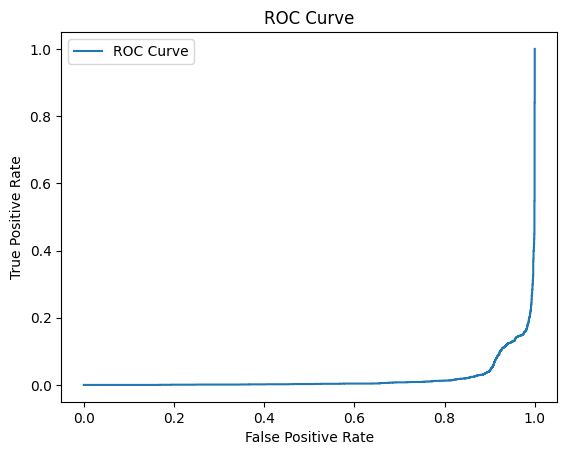

EER: 0.92 at threshold: 0.89
Test Accuracy: 61.55%
Precision: 0.63
Recall: 0.62
F1-Score: 0.61
Confusion Matrix:
[[1383 1617]
 [ 690 2310]]
AUC-ROC: 0.66


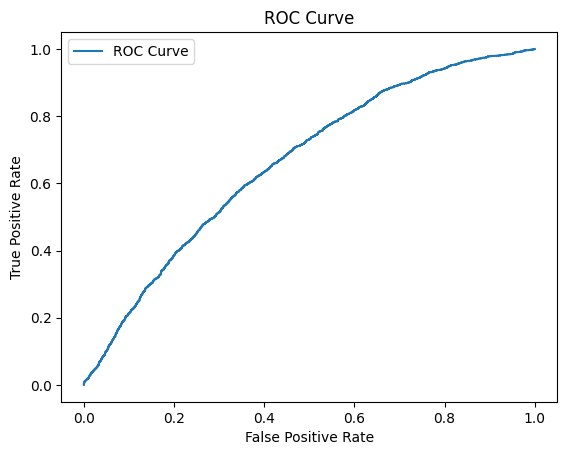

EER: 0.38 at threshold: 0.77


In [9]:
# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut"  # Replace with the path to your spoof audio directory

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_fmcc_loader = DataLoader(fmcc_dataset, batch_size=32, shuffle= False)
evaluate_model(model, test_fmcc_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

## Test with jstu dataset

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/jsut_spoof"  # Replace with the path to your spoof audio directory

jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_jsut_loader = DataLoader(jsut_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_jsut_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  # Replace with the path to your spoof audio directory

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_lj_loader = DataLoader(ljspeech_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_lj_loader, device='cuda' if torch.cuda.is_available() else 'cpu')




# V3 
- introduce weight_decay in optimiser 

In [ ]:
import torch
import torch.optim as optim

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 10
early_stopping_patience = 3  # Early stopping patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)  # Reduce LR on plateau
best_val_loss = float('inf')



# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage

    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    
    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # You could also save the model here: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs


In [ ]:
import torch
from sklearn.metrics import roc_curve, auc

# Assuming `model` is your trained RawNet model and `test_loader` is your DataLoader for the test set
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to track performance metrics
    total_correct = 0
    total_samples = 0
    
    # To store outputs and labels for EER calculation
    all_scores = []
    all_labels = []

    # Disable gradient computation
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device (GPU/CPU)
            data, labels = data.to(device), labels.to(device)
            
            # Forward pass: Get model predictions
            outputs = model(data)
            
            # Get the predicted class (highest score in the output)
            _, predicted = torch.max(outputs, dim=1)
            
            # Track the number of correct predictions
            total_correct += (predicted == labels).sum().item()
            
            # Track total number of samples
            total_samples += labels.size(0)
            
            # Store scores and labels
            all_scores.extend(outputs[:, 1].cpu().numpy())  # Assuming binary classification; adjust index for multi-class
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = total_correct / total_samples * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Calculate EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    fnr = 1 - tpr  # False Negative Rate
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]  # Find the threshold where FNR = FPR
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]  # EER value
    print(f"EER: {eer:.2f} at threshold: {eer_threshold:.2f}")

# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')


## Load & Test Model 

#### Testing robustness of model with external datasets 
FMCC dataset
- contains Chinese audios 

In [ ]:
import os
import random
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TestAudioDataset(Dataset):
    def __init__(self, bonafide_dir, spoof_dir, num_samples = 3000, transform=None):
        """
        Initialize the dataset with bonafide and spoof directories.
        
        Args:
            bonafide_dir (str): Path to the directory with bonafide audio files.
            spoof_dir (str): Path to the directory with spoofed audio files.
            transform (callable, optional): Optional transform to be applied to the audio data.
        """
        self.bonafide_dir = bonafide_dir
        self.spoof_dir = spoof_dir
        self.transform = transform
        
        # Get a list of bonafide files and spoofed files
        self.bonafide_files = [os.path.join(bonafide_dir, f) for f in os.listdir(bonafide_dir) if f.endswith('.wav')]
        self.spoof_files = [os.path.join(spoof_dir, f) for f in os.listdir(spoof_dir) if f.endswith('.wav')]

        # Randomly sample files
        self.bonafide_files = random.sample(self.bonafide_files, min(num_samples, len(self.bonafide_files)))
        self.spoof_files = random.sample(self.spoof_files, min(num_samples, len(self.spoof_files)))

        # Combine the lists and create labels
        self.audio_files = self.bonafide_files + self.spoof_files
        self.labels = [0] * len(self.bonafide_files) + [1] * len(self.spoof_files)  # 0 for bonafide, 1 for spoof

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        Get a single audio sample and its corresponding label.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            waveform (torch.Tensor): The loaded audio waveform.
            label (int): The label (1 for bonafide, 0 for spoof).
        """
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load the audio waveform
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert waveform to numpy for padding or processing if needed
        waveform = waveform.squeeze().numpy()

        # Apply any transforms if specified
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label
    
# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])

# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut" 

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_fmcc_loader = DataLoader(fmcc_dataset, batch_size=32, shuffle= False)


In [12]:
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_fmcc_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

NameError: name 'model' is not defined

In [ ]:
## Test with jstu dataset

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  
spoof_dir = "ProjectStorage/test/jsut_spoof" 
jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_jsut_loader = DataLoader(jsut_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_jsut_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
## Test with ljspeech dataset

bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut" 
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_lj_loader = DataLoader(ljspeech_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_lj_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# Model Training with Ori + Augmented Data (With Class Weights)

In [5]:
import os
import torch
import numpy as np
import torchaudio
import pandas as pd
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms


# Define the pad function to ensure fixed input size
def pad(x, max_len=64600):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    # Need to pad
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (1, num_repeats))[:, :max_len][0]
    return padded_x

# Define a custom dataset for loading your audio files and labels
class AudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the meta CSV file containing labels
        self.meta_data = pd.read_csv(meta_file)

        # Create a dictionary of filenames to labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))
        
        # Get the list of audio files in the directory
        self.audio_files = [f for f in os.listdir(audio_dir) if f in self.audio_labels]  # Only files with labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the filename and corresponding label
        audio_filename = self.audio_files[idx]
        label = self.audio_labels[audio_filename]
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to a numerical format: 0 for 'spoof', 1 for 'bona-fide'
        label = 1 if label == 'spoof' else 0

        return waveform, label


class AugmentedAudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the metadata CSV and map file numbers to labels
        self.meta_data = pd.read_csv(meta_file)
        # Extract numeric part and create a mapping for labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))

        # Filter audio files in the directory to match only those with "augmented_" prefix
        self.audio_files = [f for f in os.listdir(audio_dir) if '.wav' in f]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the augmented file name
        audio_filename = self.audio_files[idx]
        
        # Extract the original file number from the augmented file name
        file_name = audio_filename.split('_')[-1]

        # Retrieve label using the extracted file number
        label = self.audio_labels.get(file_name, 'unknown')
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        # Apply transformations if any
        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to numerical format: 0 for 'bonafide', 1 for 'spoof'
        label = 1 if label == 'spoof' else 0

        return waveform, label

# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])



# Path to the directory containing the audio files and the CSV file
train_audio_dir = 'ProjectStorage/wav_train_set'
val_audio_dir = 'ProjectStorage/wav_val_set'
test_audio_dir = 'ProjectStorage/wav_test_set'
augmented_dir = 'ProjectStorage/augmented_audio_files'

meta_file = 'ProjectStorage/meta.csv'

# Initialize the dataset with labels
train_dataset = AudioDataset(audio_dir=train_audio_dir, meta_file=meta_file, transform=audio_transforms)
val_dataset = AudioDataset(audio_dir=val_audio_dir, meta_file=meta_file, transform=audio_transforms)
test_dataset = AudioDataset(audio_dir=test_audio_dir, meta_file=meta_file, transform=audio_transforms)
augmented_dataset = AugmentedAudioDataset(audio_dir=augmented_dir, meta_file=meta_file, transform=audio_transforms)




In [6]:


combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])

# Print dataset sizes
print("Original train set size:", len(train_dataset))
print("Augmented data set size:", len(augmented_dataset))
print("Final training set size:", len(combined_train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))



Original train set size: 22236
Augmented data set size: 31779
Final training set size: 54015
Validation set size: 3178
Test set size: 6356


In [12]:
from collections import Counter

# Function to calculate label distribution
def get_label_distribution(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label)
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    distribution = {k: v / total for k, v in label_counts.items()}
    return label_counts, distribution

# Calculate label distribution for each dataset
train_counts, train_distribution = get_label_distribution(combined_train_dataset)
val_counts, val_distribution = get_label_distribution(val_dataset)
test_counts, test_distribution = get_label_distribution(test_dataset)

# Print the results
print("Training set size:", len(combined_train_dataset))
print("Training set label counts:", train_counts)
print("Training set label distribution:", train_distribution)

print("\nValidation set size:", len(val_dataset))
print("Validation set label counts:", val_counts)
print("Validation set label distribution:", val_distribution)

print("\nTest set size:", len(test_dataset))
print("Test set label counts:", test_counts)
print("Test set label distribution:", test_distribution)

Training set size: 54015
Training set label counts: Counter({0: 33893, 1: 20122})
Training set label distribution: {1: 0.3725261501434787, 0: 0.6274738498565213}

Validation set size: 3178
Validation set label counts: Counter({0: 1989, 1: 1189})
Validation set label distribution: {0: 0.6258653241032096, 1: 0.37413467589679045}

Test set size: 6356
Test set label counts: Counter({0: 4041, 1: 2315})
Test set label distribution: {1: 0.3642227816236627, 0: 0.6357772183763373}


In [8]:

# Create DataLoaders for each dataset
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_args = {
    'in_channels': 1,          # For mono audio; set to 2 for stereo
    'first_conv': 1024,         # Adjust this based on your audio length
    'filts': [20, [20,20], [20,128],[128,128]],  # These can be adjusted
    'blocks': [2,4],
    'gru_node': 1024,           # Number of GRU units
    'nb_gru_layer': 3,         # Number of GRU layers
    'nb_fc_node': 1024,         # Number of units in the fully connected layer
    'nb_classes': 2           # Change this to the number of classes in your dataset
}

model1 = RawNet(d_args, device).to(device)

In [9]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve
from torch import nn

# Class weights (do not normalize if using class frequencies)
weights = torch.tensor([1/33893, 1/20122], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 20
early_stopping_patience = 3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
best_val_loss = float('inf')

# EER Calculation Function
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fnr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Training Loop
for epoch in range(num_epochs):
    model1.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model1(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model1.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples

            # Collect scores for EER calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs[:, 1].cpu().numpy())  # Scores for the positive class

    # Calculate EER using collected labels and scores
    eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, EER: {eer:.4f}')

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # Optionally save the model: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs


Epoch [1/20], Average Loss: 0.6619, Accuracy: 59.41%
Validation - Average Loss: 0.6307, Accuracy: 64.44%, EER: 0.3356
Epoch [2/20], Average Loss: 0.6269, Accuracy: 64.31%
Validation - Average Loss: 0.5153, Accuracy: 79.39%, EER: 0.2094
Epoch [3/20], Average Loss: 0.5349, Accuracy: 72.81%
Validation - Average Loss: 0.4047, Accuracy: 80.81%, EER: 0.1741
Epoch [4/20], Average Loss: 0.4768, Accuracy: 76.56%
Validation - Average Loss: 0.3704, Accuracy: 84.58%, EER: 0.1421
Epoch [5/20], Average Loss: 0.4102, Accuracy: 81.18%
Validation - Average Loss: 0.3736, Accuracy: 87.79%, EER: 0.1102
Epoch [6/20], Average Loss: 0.3737, Accuracy: 83.85%
Validation - Average Loss: 0.6514, Accuracy: 80.81%, EER: 0.1480
Epoch [7/20], Average Loss: 0.3467, Accuracy: 85.38%
Validation - Average Loss: 0.2703, Accuracy: 91.35%, EER: 0.0883
Epoch [8/20], Average Loss: 0.3261, Accuracy: 86.33%
Validation - Average Loss: 0.1773, Accuracy: 94.34%, EER: 0.0639
Epoch [9/20], Average Loss: 0.3140, Accuracy: 86.64%
Val

In [20]:
import torch

# Assuming model1 is your PyTorch model
torch.save(model1.state_dict(), '1novrawnet2.pth')


Test Accuracy: 92.75%
Precision: 0.93
Recall: 0.93
F1-Score: 0.93
Confusion Matrix:
[[4017   24]
 [ 437 1878]]
AUC-ROC: 0.99


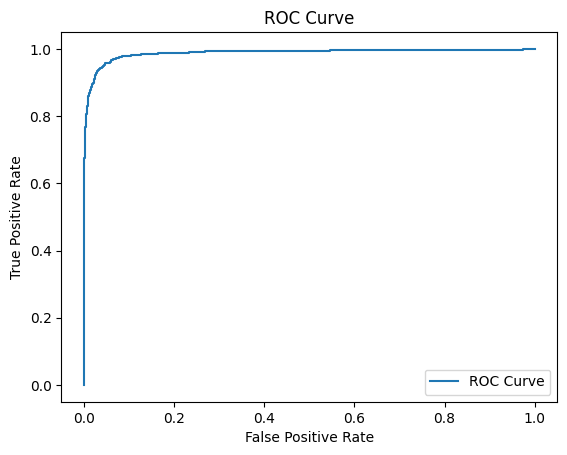

EER: 0.05 at threshold: 0.07


In [10]:
# test with test_loader ( 20% original data )
evaluate_model(model1, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

Test Accuracy: 47.63%
Precision: 0.48
Recall: 0.48
F1-Score: 0.48
Confusion Matrix:
[[1457 1543]
 [1599 1401]]
AUC-ROC: 0.47


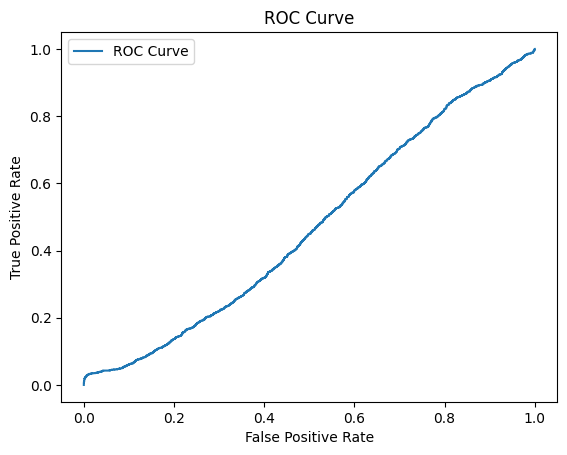

EER: 0.52 at threshold: 0.48


In [14]:
# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut"  # Replace with the path to your spoof audio directory

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_fmcc_loader = DataLoader(fmcc_dataset, batch_size=32, shuffle= False)
evaluate_model(model1, test_fmcc_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

Test Accuracy: 46.75%
Precision: 0.24
Recall: 0.47
F1-Score: 0.32
Confusion Matrix:
[[2805  195]
 [3000    0]]
AUC-ROC: 0.08


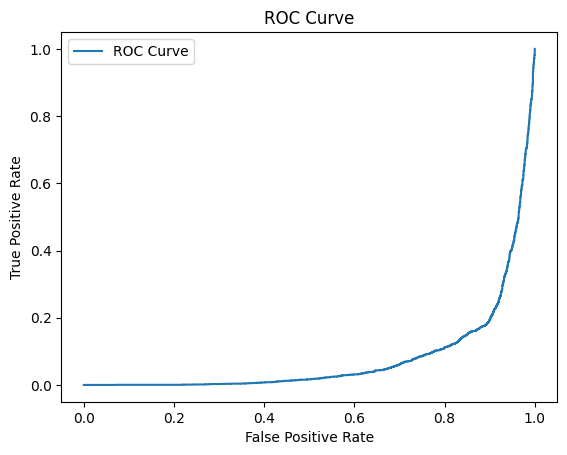

EER: 0.85 at threshold: 0.01


In [15]:
## Test with jstu dataset

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/jsut_spoof"  # Replace with the path to your spoof audio directory

jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_jsut_loader = DataLoader(jsut_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model1, test_jsut_loader, device='cuda' if torch.cuda.is_available() else 'cpu')


Test Accuracy: 51.55%
Precision: 0.53
Recall: 0.52
F1-Score: 0.46
Confusion Matrix:
[[ 569 2431]
 [ 476 2524]]
AUC-ROC: 0.51


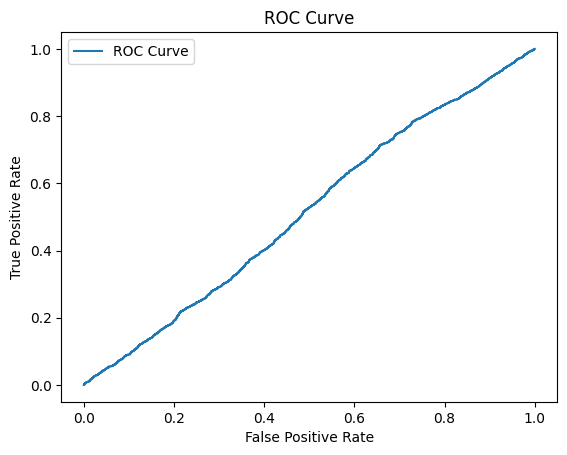

EER: 0.49 at threshold: 0.86


In [16]:


bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  # Replace with the path to your spoof audio directory

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_lj_loader = DataLoader(ljspeech_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model1, test_lj_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# Increase weight_decay to penalise large weights 

In [1]:
import os
import torch
import numpy as np
import torchaudio
import pandas as pd
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

# Define the pad function to ensure fixed input size
def pad(x, max_len=64600):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    # Need to pad
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (1, num_repeats))[:, :max_len][0]
    return padded_x

# Define a custom dataset for loading your audio files and labels
class AudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the meta CSV file containing labels
        self.meta_data = pd.read_csv(meta_file)

        # Create a dictionary of filenames to labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))
        
        # Get the list of audio files in the directory
        self.audio_files = [f for f in os.listdir(audio_dir) if f in self.audio_labels]  # Only files with labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the filename and corresponding label
        audio_filename = self.audio_files[idx]
        label = self.audio_labels[audio_filename]
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to a numerical format: 0 for 'spoof', 1 for 'bona-fide'
        label = 1 if label == 'spoof' else 0

        return waveform, label


class AugmentedAudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the metadata CSV and map file numbers to labels
        self.meta_data = pd.read_csv(meta_file)
        # Extract numeric part and create a mapping for labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))

        self.audio_files = [f for f in os.listdir(audio_dir) if '.wav' in f]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the augmented file name
        audio_filename = self.audio_files[idx]
        
        # Extract the original file number from the augmented file name
        file_name = audio_filename.split('_')[-1]

        # Retrieve label using the extracted file number
        label = self.audio_labels.get(file_name, 'unknown')
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        # Apply transformations if any
        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to numerical format: 0 for 'bonafide', 1 for 'spoof'
        label = 1 if label == 'spoof' else 0

        return waveform, label

# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])



# Path to the directory containing the audio files and the CSV file
train_audio_dir = 'ProjectStorage/wav_train_set'
val_audio_dir = 'ProjectStorage/wav_val_set'
test_audio_dir = 'ProjectStorage/wav_test_set'
augmented_dir = 'ProjectStorage/augmented_audio_files'

meta_file = 'ProjectStorage/meta.csv'

# Initialize the dataset with labels
train_dataset = AudioDataset(audio_dir=train_audio_dir, meta_file=meta_file, transform=audio_transforms)
val_dataset = AudioDataset(audio_dir=val_audio_dir, meta_file=meta_file, transform=audio_transforms)
test_dataset = AudioDataset(audio_dir=test_audio_dir, meta_file=meta_file, transform=audio_transforms)
augmented_dataset = AugmentedAudioDataset(audio_dir=augmented_dir, meta_file=meta_file, transform=audio_transforms)
combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])

# Create DataLoaders for each dataset
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np


class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, device, out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):
        super(SincConv, self).__init__()

        if in_channels != 1:
            msg = "SincConv only supports one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate  # Higher sample rates can capture more detail but require more computational power.

        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.device = device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        # initialize filterbanks using Mel scale
        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)   # Hz to mel conversion
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2, (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)

    def forward(self, x): # this method defines the forward pass of the SincConv layer 
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i] # min frequency for each band-pass filter, set the smallest and largest frequencies that the filters will listen to
            fmax = self.mel[i + 1] # max freq
            hHigh = (2 * fmax / self.sample_rate) * np.sinc(2 * fmax * self.hsupp / self.sample_rate)
            hLow = (2 * fmin / self.sample_rate) * np.sinc(2 * fmin * self.hsupp / self.sample_rate)
            hideal = hHigh - hLow
            
            self.band_pass[i, :] = Tensor(np.hamming(self.kernel_size)) * Tensor(hideal) # Hamming window smooths the filters so they don’t have sharp edges, making the model perform better.

        band_pass_filter = self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)


class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False):
        super(Residual_block, self).__init__()
        self.first = first # indicates whether it is the first block in the model, which skips BN
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=3,
                               padding=1,
                               stride=1)

        self.bn2 = nn.BatchNorm1d(num_features=nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               padding=1,
                               kernel_size=3,
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels=nb_filts[0],
                                              out_channels=nb_filts[1],
                                              padding=0,
                                              kernel_size=1,
                                              stride=1)
        else:
            self.downsample = False

        self.mp = nn.MaxPool1d(3)

    def forward(self, x): # Adds the input (identity) to the output of the convolutional layers
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()

        self.device = device

        self.Sinc_conv = SincConv(device=self.device,
                                   out_channels=d_args['filts'][0],
                                   kernel_size=d_args['first_conv'],
                                   in_channels=d_args['in_channels']
                                   )

        self.first_bn = nn.BatchNorm1d(num_features=d_args['filts'][0])
        self.selu = nn.SELU(inplace=True) # Scaled Exponential Linear Unit (activation function)
        # Next, sequential blocks of residual layers, which consist of convolutional layers with skip connections to prevent vanishing gradients
        self.block0 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], first=True)) #[20,20]
        self.block1 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1])) #[20,20]
        self.block2 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[20,128]
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block4 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block5 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.avgpool = nn.AdaptiveAvgPool1d(1) # Average over time, create a summary of the feature map

        # Attention FC layers compute attention weights for each residual block. Highlight important parts of the feature maps
        self.fc_attention0 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features=d_args['filts'][2][-1])
        
        self.gru = nn.GRU(input_size=d_args['filts'][2][-1],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1_gru = nn.Linear(in_features=d_args['gru_node'],
                                  out_features=d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features=d_args['nb_fc_node'],
                                  out_features=d_args['nb_classes'], bias=True)

        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x = x.view(nb_samp, 1, len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)  # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1)  # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1  # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)  # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2  # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1)  # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3  # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)  # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4  # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1)  # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5  # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)

        x = x.transpose(1, 2)
        x, _ = self.gru(x)  # return only hidden states of last layer
        x = x[:, -1, :]  # (batch, seq_len, hidden_size)

        x = self.fc1_gru(x)
        x = self.fc2_gru(x)
        x = self.logsoftmax(x)

        return x

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
                    out_features = l_out_features))
        return nn.Sequential(*l_fc)
    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
                first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)
            
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_args = {
    'in_channels': 1,          # For mono audio; set to 2 for stereo
    'first_conv': 1024,         # Adjust this based on your audio length
    'filts': [20, [20,20], [20,128],[128,128]],  # These can be adjusted
    'blocks': [2,4],
    'gru_node': 1024,           # Number of GRU units
    'nb_gru_layer': 3,         # Number of GRU layers
    'nb_fc_node': 1024,         # Number of units in the fully connected layer
    'nb_classes': 2           # Change this to the number of classes in your dataset
}

model = RawNet(d_args, device).to(device)


In [3]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve
from torch import nn

# Class weights (do not normalize if using class frequencies)
weights = torch.tensor([1/13930, 1/8306], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=1e-4)
num_epochs = 20
early_stopping_patience = 3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)
best_val_loss = float('inf')

# EER Calculation Function
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fnr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples

            # Collect scores for EER calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs[:, 1].cpu().numpy())  # Scores for the positive class

    # Calculate EER using collected labels and scores
    eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, EER: {eer:.4f}')

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # Optionally save the model: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs


Epoch [1/20], Average Loss: 0.6904, Accuracy: 57.12%
Validation - Average Loss: 0.5700, Accuracy: 71.65%, EER: 0.2834
Epoch [2/20], Average Loss: 0.6608, Accuracy: 62.70%
Validation - Average Loss: 0.6201, Accuracy: 65.32%, EER: 0.3246
Epoch [3/20], Average Loss: 0.6209, Accuracy: 66.50%
Validation - Average Loss: 0.6331, Accuracy: 37.41%, EER: 0.2473
Epoch [4/20], Average Loss: 0.5283, Accuracy: 74.99%
Validation - Average Loss: 0.5255, Accuracy: 83.61%, EER: 0.1775
Epoch [5/20], Average Loss: 0.5581, Accuracy: 70.75%
Validation - Average Loss: 0.5481, Accuracy: 55.73%, EER: 0.2304
Epoch [6/20], Average Loss: 0.4803, Accuracy: 77.65%
Validation - Average Loss: 0.4382, Accuracy: 83.95%, EER: 0.1674
Epoch [7/20], Average Loss: 0.4588, Accuracy: 78.85%
Validation - Average Loss: 0.3464, Accuracy: 87.48%, EER: 0.1337
Epoch [8/20], Average Loss: 0.3981, Accuracy: 82.99%
Validation - Average Loss: 0.2699, Accuracy: 92.29%, EER: 0.0967
Epoch [9/20], Average Loss: 0.4011, Accuracy: 82.84%
Val

Test Accuracy: 87.33%
Precision: 0.87
Recall: 0.87
F1-Score: 0.87
Confusion Matrix:
[[3650  391]
 [ 414 1901]]
EER: 0.13 at threshold: 0.43
AUC-ROC: 0.94


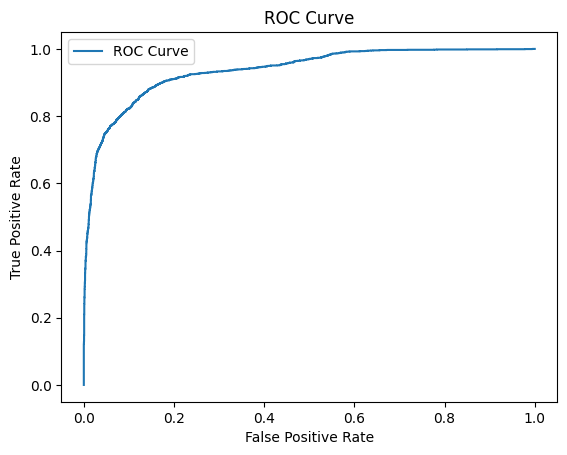

In [4]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` is your trained RawNet model and `test_loader` is your DataLoader for the test set
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track performance metrics
    all_labels = []
    all_predictions = []
    all_probs = []  # For ROC-AUC or EER if needed
    
    # Disable gradient computation
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device (GPU/CPU)
            data, labels = data.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(data)
            
            # Get the predicted class (highest score in the output)
            _, predicted = torch.max(outputs, dim=1)
            
            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            # Store probabilities for ROC-AUC/EER if needed
            probs = torch.softmax(outputs, dim=1)  # Probability distribution
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            
    # Convert lists to numpy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate Accuracy
    accuracy = np.mean(all_predictions == all_labels) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Calculate Precision, Recall, and F1-Score (binary or multi-class)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Calculate EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr  # False Negative Rate
    eer_index = np.nanargmin(np.abs(fnr - fpr))  # Find index where FNR = FPR
    eer = fpr[eer_index]  # EER value
    eer_threshold = thresholds[eer_index]  # EER threshold
    print(f"EER: {eer:.2f} at threshold: {eer_threshold:.2f}")
    
    # ROC-AUC (for binary classification)
    if len(np.unique(all_labels)) == 2:  # Only for binary classification
        auc_roc = roc_auc_score(all_labels, all_probs)
        print(f"AUC-ROC: {auc_roc:.2f}")
        
        # Optionally, plot the ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
        
        

        
# test with test_loader ( 20% original data )
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

Test Accuracy: 59.08%
Precision: 0.60
Recall: 0.59
F1-Score: 0.59
Confusion Matrix:
[[2105  895]
 [1560 1440]]
EER: 0.39 at threshold: 0.28
AUC-ROC: 0.60


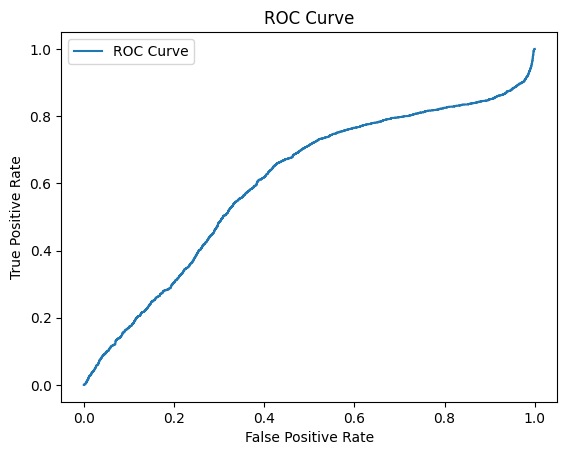

Test Accuracy: 36.30%
Precision: 0.24
Recall: 0.36
F1-Score: 0.28
Confusion Matrix:
[[2112  888]
 [2934   66]]
EER: 0.46 at threshold: 0.17
AUC-ROC: 0.55


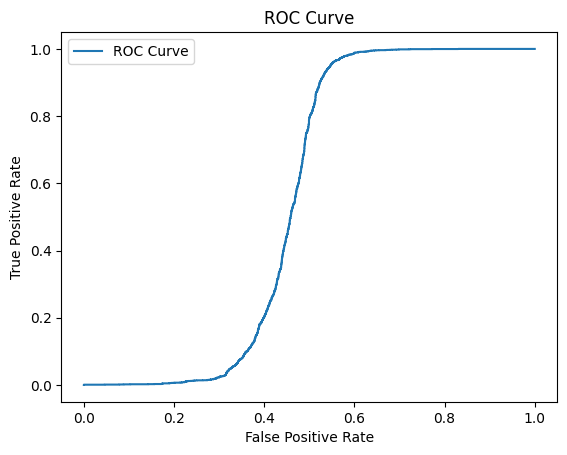

Test Accuracy: 54.80%
Precision: 0.56
Recall: 0.55
F1-Score: 0.53
Confusion Matrix:
[[1092 1908]
 [ 804 2196]]
EER: 0.46 at threshold: 0.68
AUC-ROC: 0.57


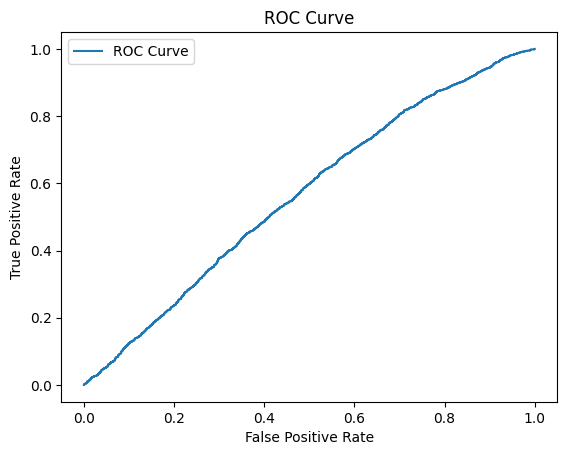

In [ ]:
import os
import random
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TestAudioDataset(Dataset):
    def __init__(self, bonafide_dir, spoof_dir, num_samples = 3000, transform=None):
        """
        Initialize the dataset with bonafide and spoof directories.
        
        Args:
            bonafide_dir (str): Path to the directory with bonafide audio files.
            spoof_dir (str): Path to the directory with spoofed audio files.
            transform (callable, optional): Optional transform to be applied to the audio data.
        """
        self.bonafide_dir = bonafide_dir
        self.spoof_dir = spoof_dir
        self.transform = transform
        
        # Get a list of bonafide files and spoofed files
        self.bonafide_files = [os.path.join(bonafide_dir, f) for f in os.listdir(bonafide_dir) if f.endswith('.wav')]
        self.spoof_files = [os.path.join(spoof_dir, f) for f in os.listdir(spoof_dir) if f.endswith('.wav')]

        # Randomly sample files
        self.bonafide_files = random.sample(self.bonafide_files, min(num_samples, len(self.bonafide_files)))
        self.spoof_files = random.sample(self.spoof_files, min(num_samples, len(self.spoof_files)))

        # Combine the lists and create labels
        self.audio_files = self.bonafide_files + self.spoof_files
        self.labels = [0] * len(self.bonafide_files) + [1] * len(self.spoof_files)  # 0 for bonafide, 1 for spoof

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        Get a single audio sample and its corresponding label.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            waveform (torch.Tensor): The loaded audio waveform.
            label (int): The label (1 for bonafide, 0 for spoof).
        """
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load the audio waveform
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert waveform to numpy for padding or processing if needed
        waveform = waveform.squeeze().numpy()

        # Apply any transforms if specified
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label
    
# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])
# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut"  # Replace with the path to your spoof audio directory

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_fmcc_loader = DataLoader(fmcc_dataset, batch_size=32, shuffle= False)
evaluate_model(model, test_fmcc_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

## Test with jstu dataset

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/jsut_spoof"  # Replace with the path to your spoof audio directory

jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_jsut_loader = DataLoader(jsut_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_jsut_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  # Replace with the path to your spoof audio directory

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_lj_loader = DataLoader(ljspeech_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_lj_loader, device='cuda' if torch.cuda.is_available() else 'cpu')






weight_decay = 1e-5
Test Accuracy: 96.02%
Precision: 0.96
Recall: 0.96
F1-Score: 0.96
Confusion Matrix:
[[4007   34]
 [ 219 2096]]
AUC-ROC: 0.99

# Add dropout layers 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np


class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, device, out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):
        super(SincConv, self).__init__()

        if in_channels != 1:
            msg = "SincConv only supports one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate  # Higher sample rates can capture more detail but require more computational power.

        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.device = device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        # initialize filterbanks using Mel scale
        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)   # Hz to mel conversion
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2, (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)

    def forward(self, x): # this method defines the forward pass of the SincConv layer 
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i] # min frequency for each band-pass filter, set the smallest and largest frequencies that the filters will listen to
            fmax = self.mel[i + 1] # max freq
            hHigh = (2 * fmax / self.sample_rate) * np.sinc(2 * fmax * self.hsupp / self.sample_rate)
            hLow = (2 * fmin / self.sample_rate) * np.sinc(2 * fmin * self.hsupp / self.sample_rate)
            hideal = hHigh - hLow
            
            self.band_pass[i, :] = Tensor(np.hamming(self.kernel_size)) * Tensor(hideal) # Hamming window smooths the filters so they don’t have sharp edges, making the model perform better.

        band_pass_filter = self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)


class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False, dropout_prob=0.3):
        super(Residual_block, self).__init__()
        self.first = first # indicates whether it is the first block in the model, which skips BN
        self.dropout = nn.Dropout(p=dropout_prob)
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=3,
                               padding=1,
                               stride=1)

        self.bn2 = nn.BatchNorm1d(num_features=nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               padding=1,
                               kernel_size=3,
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels=nb_filts[0],
                                              out_channels=nb_filts[1],
                                              padding=0,
                                              kernel_size=1,
                                              stride=1)
        else:
            self.downsample = False

        self.mp = nn.MaxPool1d(3)

    def forward(self, x): # Adds the input (identity) to the output of the convolutional layers
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
            out = self.dropout(out) # Add dropout layer
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.dropout(out) # Add drop out layer 
        out = self.conv2(out)
        

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device, dropout_prob=0.3):
        super(RawNet, self).__init__()

        self.device = device

        self.Sinc_conv = SincConv(device=self.device,
                                   out_channels=d_args['filts'][0],
                                   kernel_size=d_args['first_conv'],
                                   in_channels=d_args['in_channels']
                                   )

        self.first_bn = nn.BatchNorm1d(num_features=d_args['filts'][0])
        self.selu = nn.SELU(inplace=True) # Scaled Exponential Linear Unit (activation function)
        # Next, sequential blocks of residual layers, which consist of convolutional layers with skip connections to prevent vanishing gradients
        self.block0 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], first=True, dropout_prob=dropout_prob)) #[20,20]
        self.block1 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], dropout_prob=dropout_prob)) #[20,20]
        self.block2 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[20,128]
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[128,128]
        self.block4 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[128,128]
        self.block5 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[128,128]
        self.avgpool = nn.AdaptiveAvgPool1d(1) # Average over time, create a summary of the feature map

        # Attention FC layers compute attention weights for each residual block. Highlight important parts of the feature maps
        self.fc_attention0 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features=d_args['filts'][2][-1])
        
        self.gru = nn.GRU(input_size=d_args['filts'][2][-1],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1_gru = nn.Linear(in_features=d_args['gru_node'],
                                  out_features=d_args['nb_fc_node'])
        
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout after GRU

        self.fc2_gru = nn.Linear(in_features=d_args['nb_fc_node'],
                                  out_features=d_args['nb_classes'], bias=True)

        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x = x.view(nb_samp, 1, len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)  # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1)  # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1  # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)  # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2  # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1)  # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3  # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)  # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4  # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1)  # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5  # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)

        x = x.transpose(1, 2)
        x, _ = self.gru(x)  # return only hidden states of last layer
        x = x[:, -1, :]  # (batch, seq_len, hidden_size)

        x = self.fc1_gru(x)
        x = self.dropout(x)  # Apply dropout after GRU and before FC layer

        x = self.fc2_gru(x)
        x = self.logsoftmax(x)

        return x

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
                    out_features = l_out_features))
        return nn.Sequential(*l_fc)
    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
                first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_args = {
    'in_channels': 1,          # For mono audio; set to 2 for stereo
    'first_conv': 1024,         # Adjust this based on your audio length
    'filts': [20, [20,20], [20,128],[128,128]],  # These can be adjusted
    'blocks': [2,4],
    'gru_node': 1024,           # Number of GRU units
    'nb_gru_layer': 3,         # Number of GRU layers
    'nb_fc_node': 1024,         # Number of units in the fully connected layer
    'nb_classes': 2           # Change this to the number of classes in your dataset
}

model = RawNet(d_args, device).to(device)

In [6]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve
from torch import nn

# Class weights (do not normalize if using class frequencies)
weights = torch.tensor([1/13930, 1/8306], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 10
early_stopping_patience = 3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
best_val_loss = float('inf')

# EER Calculation Function
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fnr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples

            # Collect scores for EER calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs[:, 1].cpu().numpy())  # Scores for the positive class

    # Calculate EER using collected labels and scores
    eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, EER: {eer:.4f}')

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # Optionally save the model: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs


Epoch [1/10], Average Loss: 0.5774, Accuracy: 68.64%
Validation - Average Loss: 0.6150, Accuracy: 63.62%, EER: 0.3204
Epoch [2/10], Average Loss: 0.3138, Accuracy: 87.49%
Validation - Average Loss: 1.6453, Accuracy: 49.06%, EER: 0.4365
Epoch [3/10], Average Loss: 0.2619, Accuracy: 89.26%
Validation - Average Loss: 0.6932, Accuracy: 62.59%, EER: 0.3524
Epoch [4/10], Average Loss: 0.3725, Accuracy: 83.94%
Validation - Average Loss: 0.2098, Accuracy: 93.14%, EER: 0.0782
Epoch [5/10], Average Loss: 0.2188, Accuracy: 92.32%
Validation - Average Loss: 0.2158, Accuracy: 93.39%, EER: 0.0681
Epoch [6/10], Average Loss: 0.1775, Accuracy: 93.84%
Validation - Average Loss: 0.3163, Accuracy: 88.58%, EER: 0.1001
Epoch [7/10], Average Loss: 0.1615, Accuracy: 94.43%
Validation - Average Loss: 0.6571, Accuracy: 84.08%, EER: 0.0858
Early stopping triggered


Test Accuracy: 84.88%
Precision: 0.87
Recall: 0.85
F1-Score: 0.84
Confusion Matrix:
[[3983   58]
 [ 903 1412]]
AUC-ROC: 0.97


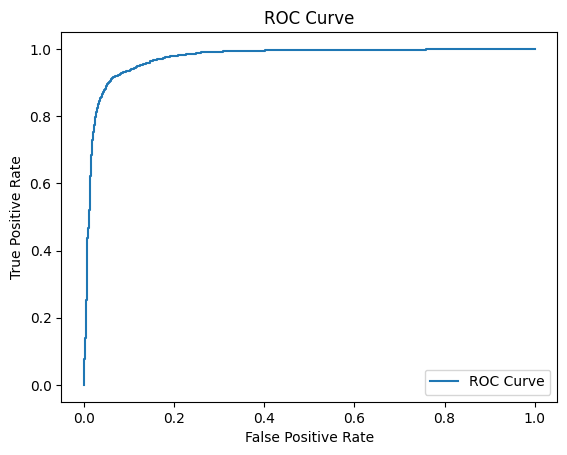

In [8]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt



# Assuming `model` is your trained RawNet model and `test_loader` is your DataLoader for the test set
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track performance metrics
    all_labels = []
    all_predictions = []
    all_probs = []  # For ROC-AUC or EER if needed
    
    # Disable gradient computation
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device (GPU/CPU)
            data, labels = data.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(data)
            
            # Get the predicted class (highest score in the output)
            _, predicted = torch.max(outputs, dim=1)
            
            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            # Store probabilities for ROC-AUC/EER if needed
            probs = torch.softmax(outputs, dim=1)  # Probability distribution
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            
    # Convert lists to numpy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate Accuracy
    accuracy = np.mean(all_predictions == all_labels) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Calculate Precision, Recall, and F1-Score (binary or multi-class)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # ROC-AUC (for binary classification)
    if len(np.unique(all_labels)) == 2:  # Only for binary classification
        auc_roc = roc_auc_score(all_labels, all_probs)
        print(f"AUC-ROC: {auc_roc:.2f}")
        
        # Optionally, plot the ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
# test with test_loader ( 20% original data )
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')


Test Accuracy: 54.57%
Precision: 0.55
Recall: 0.55
F1-Score: 0.54
Confusion Matrix:
[[1519 1481]
 [1245 1755]]
AUC-ROC: 0.54


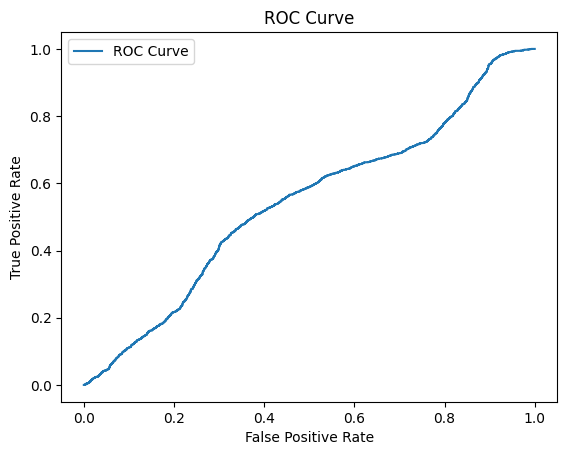

In [10]:
import os
import random
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TestAudioDataset(Dataset):
    def __init__(self, bonafide_dir, spoof_dir, num_samples = 3000, transform=None):
        """
        Initialize the dataset with bonafide and spoof directories.
        
        Args:
            bonafide_dir (str): Path to the directory with bonafide audio files.
            spoof_dir (str): Path to the directory with spoofed audio files.
            transform (callable, optional): Optional transform to be applied to the audio data.
        """
        self.bonafide_dir = bonafide_dir
        self.spoof_dir = spoof_dir
        self.transform = transform
        
        # Get a list of bonafide files and spoofed files
        self.bonafide_files = [os.path.join(bonafide_dir, f) for f in os.listdir(bonafide_dir) if f.endswith('.wav')]
        self.spoof_files = [os.path.join(spoof_dir, f) for f in os.listdir(spoof_dir) if f.endswith('.wav')]

        # Randomly sample files
        self.bonafide_files = random.sample(self.bonafide_files, min(num_samples, len(self.bonafide_files)))
        self.spoof_files = random.sample(self.spoof_files, min(num_samples, len(self.spoof_files)))

        # Combine the lists and create labels
        self.audio_files = self.bonafide_files + self.spoof_files
        self.labels = [0] * len(self.bonafide_files) + [1] * len(self.spoof_files)  # 0 for bonafide, 1 for spoof

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        Get a single audio sample and its corresponding label.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            waveform (torch.Tensor): The loaded audio waveform.
            label (int): The label (1 for bonafide, 0 for spoof).
        """
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load the audio waveform
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert waveform to numpy for padding or processing if needed
        waveform = waveform.squeeze().numpy()

        # Apply any transforms if specified
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label
    
# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])

# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut"  # Replace with the path to your spoof audio directory

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_fmcc_loader = DataLoader(fmcc_dataset, batch_size=32, shuffle= False)
evaluate_model(model, test_fmcc_loader, device='cuda' if torch.cuda.is_available() else 'cpu')





Test Accuracy: 50.00%
Precision: 0.25
Recall: 0.50
F1-Score: 0.33
Confusion Matrix:
[[3000    0]
 [3000    0]]
AUC-ROC: 0.12


/home/ubuntu/studies/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


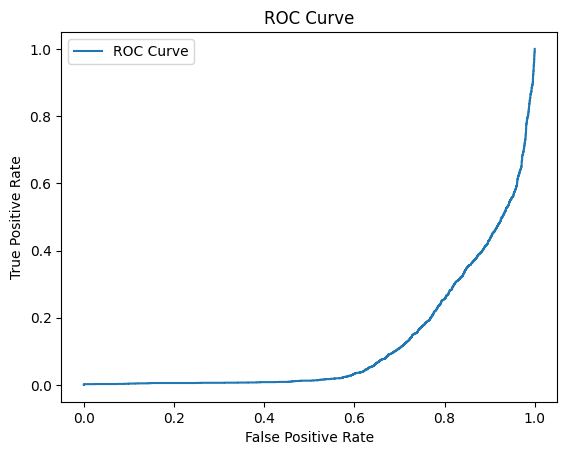

In [11]:
## Test with jstu dataset

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/jsut_spoof"  # Replace with the path to your spoof audio directory

jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_jsut_loader = DataLoader(jsut_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_jsut_loader, device='cuda' if torch.cuda.is_available() else 'cpu')



Test Accuracy: 51.25%
Precision: 0.54
Recall: 0.51
F1-Score: 0.41
Confusion Matrix:
[[2763  237]
 [2688  312]]
AUC-ROC: 0.51


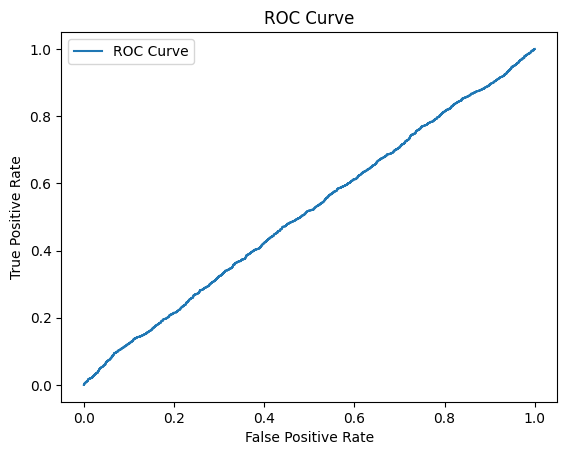

In [26]:

bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  # Replace with the path to your spoof audio directory

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_lj_loader = DataLoader(ljspeech_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_lj_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# V4: remove some dropout layers 

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np


class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, device, out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):
        super(SincConv, self).__init__()

        if in_channels != 1:
            msg = "SincConv only supports one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate  # Higher sample rates can capture more detail but require more computational power.

        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.device = device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        # initialize filterbanks using Mel scale
        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)   # Hz to mel conversion
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2, (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)

    def forward(self, x): # this method defines the forward pass of the SincConv layer 
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i] # min frequency for each band-pass filter, set the smallest and largest frequencies that the filters will listen to
            fmax = self.mel[i + 1] # max freq
            hHigh = (2 * fmax / self.sample_rate) * np.sinc(2 * fmax * self.hsupp / self.sample_rate)
            hLow = (2 * fmin / self.sample_rate) * np.sinc(2 * fmin * self.hsupp / self.sample_rate)
            hideal = hHigh - hLow
            
            self.band_pass[i, :] = Tensor(np.hamming(self.kernel_size)) * Tensor(hideal) # Hamming window smooths the filters so they don’t have sharp edges, making the model perform better.

        band_pass_filter = self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)


class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False, dropout_prob=0.3):
        super(Residual_block, self).__init__()
        self.first = first # indicates whether it is the first block in the model, which skips BN
        self.dropout = nn.Dropout(p=dropout_prob)
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=3,
                               padding=1,
                               stride=1)

        self.bn2 = nn.BatchNorm1d(num_features=nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               padding=1,
                               kernel_size=3,
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels=nb_filts[0],
                                              out_channels=nb_filts[1],
                                              padding=0,
                                              kernel_size=1,
                                              stride=1)
        else:
            self.downsample = False

        self.mp = nn.MaxPool1d(3)

    def forward(self, x): # Adds the input (identity) to the output of the convolutional layers
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
            out = self.dropout(out) # Add dropout layer
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.dropout(out) # Add drop out layer 
        out = self.conv2(out)
        

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device, dropout_prob=0.5):
        super(RawNet, self).__init__()

        self.device = device

        self.Sinc_conv = SincConv(device=self.device,
                                   out_channels=d_args['filts'][0],
                                   kernel_size=d_args['first_conv'],
                                   in_channels=d_args['in_channels']
                                   )

        self.first_bn = nn.BatchNorm1d(num_features=d_args['filts'][0])
        self.selu = nn.SELU(inplace=True) # Scaled Exponential Linear Unit (activation function)
        # Next, sequential blocks of residual layers, which consist of convolutional layers with skip connections to prevent vanishing gradients
        self.block0 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], first=True, dropout_prob=dropout_prob)) #[20,20]
        self.block1 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], dropout_prob=dropout_prob)) #[20,20]
        self.block2 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[20,128]
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[128,128]
        self.block4 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[128,128]
        self.block5 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2], dropout_prob=dropout_prob)) #[128,128]
        self.avgpool = nn.AdaptiveAvgPool1d(1) # Average over time, create a summary of the feature map

        # Attention FC layers compute attention weights for each residual block. Highlight important parts of the feature maps
        self.fc_attention0 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features=d_args['filts'][2][-1])
        
        self.gru = nn.GRU(input_size=d_args['filts'][2][-1],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1_gru = nn.Linear(in_features=d_args['gru_node'],
                                  out_features=d_args['nb_fc_node'])
        
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout after GRU

        self.fc2_gru = nn.Linear(in_features=d_args['nb_fc_node'],
                                  out_features=d_args['nb_classes'], bias=True)

        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x = x.view(nb_samp, 1, len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)  # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1)  # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1  # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)  # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2  # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1)  # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3  # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)  # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4  # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1)  # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5  # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)

        x = x.transpose(1, 2)
        x, _ = self.gru(x)  # return only hidden states of last layer
        x = x[:, -1, :]  # (batch, seq_len, hidden_size)

        x = self.fc1_gru(x)
        x = self.dropout(x)  # Apply dropout after GRU and before FC layer

        x = self.fc2_gru(x)
        x = self.logsoftmax(x)

        return x

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
                    out_features = l_out_features))
        return nn.Sequential(*l_fc)
    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
                first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)


In [39]:
model = RawNet(d_args, device).to(device)

# Hyperparameter tuning 


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np


class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, device, out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):
        super(SincConv, self).__init__()

        if in_channels != 1:
            msg = "SincConv only supports one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate  # Higher sample rates can capture more detail but require more computational power.

        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.device = device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        # initialize filterbanks using Mel scale
        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)   # Hz to mel conversion
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2, (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)

    def forward(self, x): # this method defines the forward pass of the SincConv layer 
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i] # min frequency for each band-pass filter, set the smallest and largest frequencies that the filters will listen to
            fmax = self.mel[i + 1] # max freq
            hHigh = (2 * fmax / self.sample_rate) * np.sinc(2 * fmax * self.hsupp / self.sample_rate)
            hLow = (2 * fmin / self.sample_rate) * np.sinc(2 * fmin * self.hsupp / self.sample_rate)
            hideal = hHigh - hLow
            
            self.band_pass[i, :] = Tensor(np.hamming(self.kernel_size)) * Tensor(hideal) # Hamming window smooths the filters so they don’t have sharp edges, making the model perform better.

        band_pass_filter = self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)


class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False):
        super(Residual_block, self).__init__()
        self.first = first # indicates whether it is the first block in the model, which skips BN
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=3,
                               padding=1,
                               stride=1)

        self.bn2 = nn.BatchNorm1d(num_features=nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               padding=1,
                               kernel_size=3,
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels=nb_filts[0],
                                              out_channels=nb_filts[1],
                                              padding=0,
                                              kernel_size=1,
                                              stride=1)
        else:
            self.downsample = False

        self.mp = nn.MaxPool1d(3)

    def forward(self, x): # Adds the input (identity) to the output of the convolutional layers
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()

        self.device = device

        self.Sinc_conv = SincConv(device=self.device,
                                   out_channels=d_args['filts'][0],
                                   kernel_size=d_args['first_conv'],
                                   in_channels=d_args['in_channels']
                                   )

        self.first_bn = nn.BatchNorm1d(num_features=d_args['filts'][0])
        self.selu = nn.SELU(inplace=True) # Scaled Exponential Linear Unit (activation function)
        # Next, sequential blocks of residual layers, which consist of convolutional layers with skip connections to prevent vanishing gradients
        self.block0 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], first=True)) #[20,20]
        self.block1 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1])) #[20,20]
        self.block2 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[20,128]
        # d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][3])) #[128,128]
        self.block4 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][3])) #[128,128]
        self.block5 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][3])) #[128,128]
        self.avgpool = nn.AdaptiveAvgPool1d(1) # Average over time, create a summary of the feature map

        # Attention FC layers compute attention weights for each residual block. Highlight important parts of the feature maps
        self.fc_attention0 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features=d_args['filts'][3][-1],
                                                     l_out_features=d_args['filts'][3][-1])
        self.fc_attention3 = self._make_attention_fc(in_features=d_args['filts'][3][-1],
                                                     l_out_features=d_args['filts'][3][-1])
        self.fc_attention4 = self._make_attention_fc(in_features=d_args['filts'][3][-1],
                                                     l_out_features=d_args['filts'][3][-1])
        self.fc_attention5 = self._make_attention_fc(in_features=d_args['filts'][3][-1],
                                                     l_out_features=d_args['filts'][3][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features=d_args['filts'][3][-1])
        
        self.gru = nn.GRU(input_size=d_args['filts'][3][-1],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1_gru = nn.Linear(in_features=d_args['gru_node'],
                                  out_features=d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features=d_args['nb_fc_node'],
                                  out_features=d_args['nb_classes'], bias=True)

        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x = x.view(nb_samp, 1, len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)  # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1)  # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1  # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)  # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2  # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1)  # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3  # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)  # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4  # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1)  # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5  # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)

        x = x.transpose(1, 2)
        x, _ = self.gru(x)  # return only hidden states of last layer
        x = x[:, -1, :]  # (batch, seq_len, hidden_size)

        x = self.fc1_gru(x)
        x = self.fc2_gru(x)
        x = self.logsoftmax(x)

        return x

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
                    out_features = l_out_features))
        return nn.Sequential(*l_fc)
    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
                first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_args = {
    'in_channels': 1,          # For mono audio; set to 2 for stereo
    'first_conv': 1024,         # Adjust this based on your audio length
    'filts': [20, [20,20], [20,128], [128,128]],  # These can be adjusted
    'blocks': [2,4],
    'gru_node': 1024,           # Number of GRU units
    'nb_gru_layer': 3,         # Number of GRU layers
    'nb_fc_node': 1024,         # Number of units in the fully connected layer
    'nb_classes': 2           # Change this to the number of classes in your dataset
}

In [3]:
d_args['filts']

[20, [20, 20], [20, 128], [128, 128]]

In [6]:
%pip install optuna

     |████████████████████████████████| 362 kB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 72.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 641 kB 71.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import optuna
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve
from torch import nn

# Assuming device, train_loader, and val_loader are defined elsewhere
# Example: device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model evaluation function for tuning
def objective(trial):
    # Hyperparameter suggestions from Optuna
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Define DataLoaders with the suggested batch_size
    train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    

    # Define model, criterion, optimizer, and scheduler
    model = RawNet(d_args, device).to(device)
    weights = torch.tensor([1/33893, 1/20122], device=device)
    # Example class weights
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)

    num_epochs = 20
    early_stopping_patience = 3
    best_val_loss = float('inf')
    early_stopping_counter = 0

    # EER Calculation Function
    def calculate_eer(y_true, y_scores):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
        eer = fnr[np.nanargmin(np.abs(fnr - fpr))]
        return eer, eer_threshold

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0
        total_correct = 0
        total_samples = 0

        # Training batch loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss and calculate accuracy
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(train_loader)
        accuracy = total_correct / total_samples * 100

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_samples = 0
        all_labels = []
        all_scores = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_samples += labels.size(0)

                # Collect scores for EER calculation
                all_labels.extend(labels.cpu().numpy())
                all_scores.extend(outputs[:, 1].cpu().numpy())  # Scores for the positive class

        # Calculate EER
        eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))

        # Calculate average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_samples * 100

        # Print validation results for monitoring during trials
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, '
              f'Accuracy: {val_accuracy:.2f}%, EER: {eer:.4f}')

        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    # Return final validation accuracy or loss for Optuna to maximize or minimize
    return best_val_loss 

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best hyperparameters: ", study.best_params)

[I 2024-11-04 15:13:49,215] A new study created in memory with name: no-name-69d2eae4-bee4-4cdb-8126-aa95ea0c9da8
/tmp/ipykernel_1510796/1886950687.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_1510796/1886950687.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


Epoch [1/20], Validation Loss: 0.1618, Accuracy: 93.36%, EER: 0.0563
Epoch [2/20], Validation Loss: 0.0978, Accuracy: 96.26%, EER: 0.0362
Epoch [3/20], Validation Loss: 0.0934, Accuracy: 96.73%, EER: 0.0387
Epoch [4/20], Validation Loss: 0.0787, Accuracy: 97.92%, EER: 0.0219
Epoch [5/20], Validation Loss: 0.0997, Accuracy: 96.00%, EER: 0.0210
Epoch [6/20], Validation Loss: 0.0407, Accuracy: 98.80%, EER: 0.0135
Epoch [7/20], Validation Loss: 0.0442, Accuracy: 98.55%, EER: 0.0151
Epoch [8/20], Validation Loss: 0.0833, Accuracy: 96.29%, EER: 0.0177


[I 2024-11-04 16:47:15,280] Trial 0 finished with value: 0.040743630891665814 and parameters: {'lr': 0.0001289481680201228, 'weight_decay': 1.4361736713939784e-05, 'batch_size': 64}. Best is trial 0 with value: 0.040743630891665814.


Epoch [9/20], Validation Loss: 0.0472, Accuracy: 98.21%, EER: 0.0185
Early stopping triggered


/tmp/ipykernel_1510796/1886950687.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_1510796/1886950687.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


Epoch [1/20], Validation Loss: 0.2190, Accuracy: 91.85%, EER: 0.0774
Epoch [2/20], Validation Loss: 0.1241, Accuracy: 95.97%, EER: 0.0446
Epoch [3/20], Validation Loss: 0.0635, Accuracy: 98.17%, EER: 0.0193
Epoch [4/20], Validation Loss: 0.0815, Accuracy: 96.88%, EER: 0.0143
Epoch [5/20], Validation Loss: 0.0576, Accuracy: 98.52%, EER: 0.0185
Epoch [6/20], Validation Loss: 0.0292, Accuracy: 99.15%, EER: 0.0093
Epoch [7/20], Validation Loss: 0.0437, Accuracy: 98.40%, EER: 0.0118
Epoch [8/20], Validation Loss: 0.0389, Accuracy: 98.71%, EER: 0.0143
Epoch [9/20], Validation Loss: 0.0277, Accuracy: 99.43%, EER: 0.0109
Epoch [10/20], Validation Loss: 0.0438, Accuracy: 98.65%, EER: 0.0143
Epoch [11/20], Validation Loss: 0.0202, Accuracy: 99.37%, EER: 0.0076
Epoch [12/20], Validation Loss: 0.0245, Accuracy: 99.37%, EER: 0.0076
Epoch [13/20], Validation Loss: 0.0355, Accuracy: 99.02%, EER: 0.0109


[I 2024-11-04 19:30:23,240] Trial 1 finished with value: 0.020213041801471262 and parameters: {'lr': 0.00019928099623700788, 'weight_decay': 7.607929187445042e-05, 'batch_size': 32}. Best is trial 1 with value: 0.020213041801471262.


Epoch [14/20], Validation Loss: 0.0220, Accuracy: 99.37%, EER: 0.0076
Early stopping triggered


/tmp/ipykernel_1510796/1886950687.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_1510796/1886950687.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


Epoch [1/20], Validation Loss: 0.2755, Accuracy: 90.84%, EER: 0.0917
Epoch [2/20], Validation Loss: 0.2151, Accuracy: 92.51%, EER: 0.0824
Epoch [3/20], Validation Loss: 0.1578, Accuracy: 93.39%, EER: 0.0521
Epoch [4/20], Validation Loss: 0.1334, Accuracy: 94.87%, EER: 0.0521
Epoch [5/20], Validation Loss: 0.1494, Accuracy: 93.86%, EER: 0.0580
Epoch [6/20], Validation Loss: 0.0996, Accuracy: 96.00%, EER: 0.0378
Epoch [7/20], Validation Loss: 0.1037, Accuracy: 95.78%, EER: 0.0362
Epoch [8/20], Validation Loss: 0.0879, Accuracy: 96.76%, EER: 0.0345
Epoch [9/20], Validation Loss: 0.0996, Accuracy: 96.76%, EER: 0.0353
Epoch [10/20], Validation Loss: 0.0916, Accuracy: 96.63%, EER: 0.0336
Epoch [11/20], Validation Loss: 0.0642, Accuracy: 97.26%, EER: 0.0227
Epoch [12/20], Validation Loss: 0.0835, Accuracy: 96.98%, EER: 0.0303
Epoch [13/20], Validation Loss: 0.0728, Accuracy: 96.92%, EER: 0.0227
Epoch [14/20], Validation Loss: 0.0578, Accuracy: 97.80%, EER: 0.0210
Epoch [15/20], Validation Los

[I 2024-11-04 23:31:43,768] Trial 2 finished with value: 0.04134024932805622 and parameters: {'lr': 1.4923835178008934e-05, 'weight_decay': 1.5823535367118344e-05, 'batch_size': 16}. Best is trial 1 with value: 0.020213041801471262.


Epoch [20/20], Validation Loss: 0.0629, Accuracy: 97.80%, EER: 0.0193


/tmp/ipykernel_1510796/1886950687.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_1510796/1886950687.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


Epoch [1/20], Validation Loss: 0.7242, Accuracy: 57.71%, EER: 0.5198
Epoch [2/20], Validation Loss: 1.6589, Accuracy: 38.89%, EER: 0.5728
Epoch [3/20], Validation Loss: 0.6916, Accuracy: 40.31%, EER: 0.4205
Epoch [4/20], Validation Loss: 0.7526, Accuracy: 37.73%, EER: 0.5408
Epoch [5/20], Validation Loss: 0.6932, Accuracy: 62.43%, EER: 0.5585


[I 2024-11-05 00:40:44,094] Trial 3 finished with value: 0.6915713918209075 and parameters: {'lr': 0.006713015275582812, 'weight_decay': 0.0005828485131502925, 'batch_size': 32}. Best is trial 1 with value: 0.020213041801471262.


Epoch [6/20], Validation Loss: 0.6933, Accuracy: 37.48%, EER: 0.4087
Early stopping triggered


/tmp/ipykernel_1510796/1886950687.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_1510796/1886950687.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


Epoch [1/20], Validation Loss: 0.2162, Accuracy: 92.01%, EER: 0.0732
Epoch [2/20], Validation Loss: 0.1329, Accuracy: 95.53%, EER: 0.0471
Epoch [3/20], Validation Loss: 0.1018, Accuracy: 96.00%, EER: 0.0370
Epoch [4/20], Validation Loss: 0.1192, Accuracy: 95.56%, EER: 0.0412
Epoch [5/20], Validation Loss: 0.0978, Accuracy: 96.13%, EER: 0.0269
Epoch [6/20], Validation Loss: 0.0827, Accuracy: 97.51%, EER: 0.0261
Epoch [7/20], Validation Loss: 0.0486, Accuracy: 98.27%, EER: 0.0151
Epoch [8/20], Validation Loss: 0.0574, Accuracy: 98.14%, EER: 0.0185
Epoch [9/20], Validation Loss: 0.0767, Accuracy: 96.76%, EER: 0.0261
Epoch [10/20], Validation Loss: 0.0410, Accuracy: 98.30%, EER: 0.0143


In [21]:
print(model)

RawNet(
  (Sinc_conv): SincConv()
  (first_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu): SELU(inplace=True)
  (block0): Sequential(
    (0): Residual_block(
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block1): Sequential(
    (0): Residual_block(
      (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(20, 20, kernel_size=(3,), stride

In [19]:
best_lr = 0.00019928099623700788
best_weight_decay = 7.607929187445042e-05
best_batch_size=  32
model = RawNet(d_args, device).to(device)
# Create DataLoaders for each dataset
train_loader = DataLoader(combined_train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)


In [20]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve
from torch import nn

# Class weights (do not normalize if using class frequencies)
weights = torch.tensor([1/33893, 1/20122], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
num_epochs = 20
early_stopping_patience = 3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)
best_val_loss = float('inf')

# EER Calculation Function
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fnr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples

            # Collect scores for EER calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs[:, 1].cpu().numpy())  # Scores for the positive class

    # Calculate EER using collected labels and scores
    eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, EER: {eer:.4f}')

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # Optionally save the model: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs

Epoch [1/20], Average Loss: 0.4522, Accuracy: 78.36%
Validation - Average Loss: 0.2423, Accuracy: 91.69%, EER: 0.0824
Epoch [2/20], Average Loss: 0.2876, Accuracy: 88.01%
Validation - Average Loss: 0.1225, Accuracy: 95.72%, EER: 0.0387
Epoch [3/20], Average Loss: 0.2239, Accuracy: 90.73%
Validation - Average Loss: 0.1053, Accuracy: 96.63%, EER: 0.0252
Epoch [4/20], Average Loss: 0.1898, Accuracy: 92.25%
Validation - Average Loss: 0.0635, Accuracy: 97.95%, EER: 0.0235
Epoch [5/20], Average Loss: 0.1636, Accuracy: 93.37%
Validation - Average Loss: 0.0455, Accuracy: 98.21%, EER: 0.0168
Epoch [6/20], Average Loss: 0.1416, Accuracy: 94.42%
Validation - Average Loss: 0.0467, Accuracy: 98.65%, EER: 0.0160
Epoch [7/20], Average Loss: 0.1249, Accuracy: 95.17%
Validation - Average Loss: 0.0628, Accuracy: 98.43%, EER: 0.0177
Epoch [8/20], Average Loss: 0.1139, Accuracy: 95.62%
Validation - Average Loss: 0.0553, Accuracy: 97.64%, EER: 0.0101
Early stopping triggered


In [21]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` is your trained RawNet model and `test_loader` is your DataLoader for the test set
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track performance metrics
    all_labels = []
    all_predictions = []
    all_probs = []  # For ROC-AUC or EER if needed
    
    # Disable gradient computation
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device (GPU/CPU)
            data, labels = data.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(data)
            
            # Get the predicted class (highest score in the output)
            _, predicted = torch.max(outputs, dim=1)
            
            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            # Store probabilities for ROC-AUC/EER if needed
            probs = torch.softmax(outputs, dim=1)  # Probability distribution
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            
    # Convert lists to numpy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate Accuracy
    accuracy = np.mean(all_predictions == all_labels) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Calculate Precision, Recall, and F1-Score (binary or multi-class)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # ROC-AUC (for binary classification)
    if len(np.unique(all_labels)) == 2:  # Only for binary classification
        auc_roc = roc_auc_score(all_labels, all_probs)
        print(f"AUC-ROC: {auc_roc:.2f}")
        
        # Optionally, plot the ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
        
        # Calculate EER
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        fnr = 1 - tpr  # False Negative Rate
        eer_index = np.nanargmin(np.abs(fnr - fpr))  # Find index where FNR = FPR
        eer = fpr[eer_index]  # EER value
        eer_threshold = thresholds[eer_index]  # EER threshold
        print(f"EER: {eer:.2f} at threshold: {eer_threshold:.2f}")


In [20]:
for batch in train_loader:
    waveforms, labels = batch
    print(waveforms.shape)  # This will show the batch shape, e.g., (batch_size, num_channels, num_samples)
    break  # Only need the first batc

torch.Size([32, 64600])


Test Accuracy: 98.27%
Precision: 0.98
Recall: 0.98
F1-Score: 0.98
Confusion Matrix:
[[3944   97]
 [  13 2302]]
AUC-ROC: 1.00


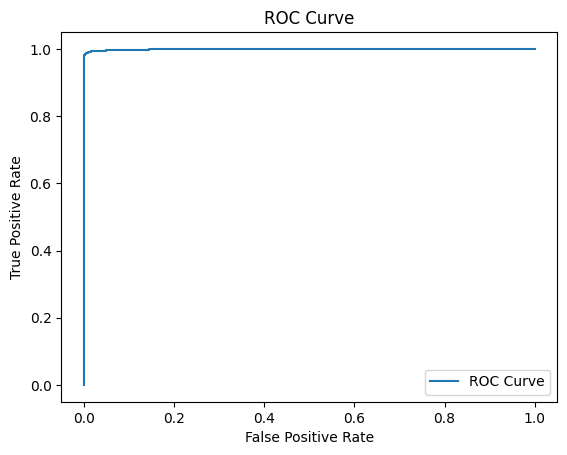

EER: 0.01 at threshold: 0.85


In [22]:
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.save(model.state_dict(), 'best_model.pth')

Test Accuracy: 53.98%
Precision: 0.54
Recall: 0.54
F1-Score: 0.53
Confusion Matrix:
[[1928 1072]
 [1689 1311]]
AUC-ROC: 0.53


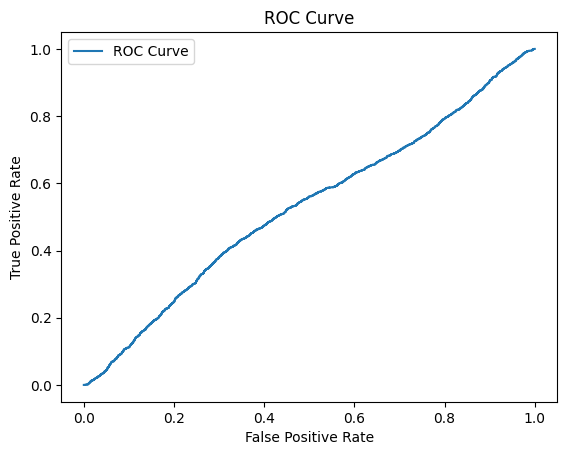

EER: 0.47 at threshold: 0.17
Test Accuracy: 41.70%
Precision: 0.23
Recall: 0.42
F1-Score: 0.29
Confusion Matrix:
[[2500  500]
 [2998    2]]
AUC-ROC: 0.08


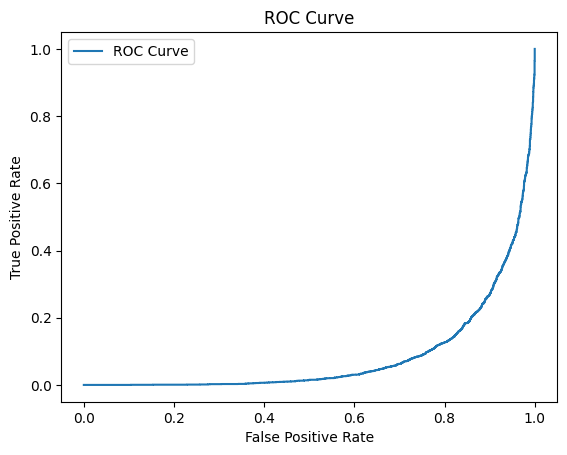

EER: 0.84 at threshold: 0.02
Test Accuracy: 51.28%
Precision: 0.54
Recall: 0.51
F1-Score: 0.42
Confusion Matrix:
[[2735  265]
 [2658  342]]
AUC-ROC: 0.60


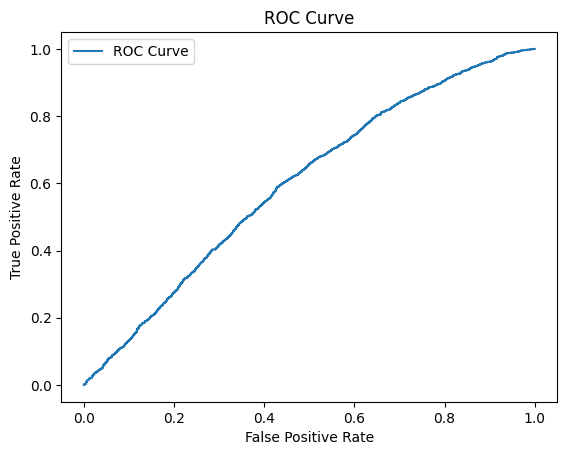

EER: 0.42 at threshold: 0.03


In [24]:
import os
import random
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TestAudioDataset(Dataset):
    def __init__(self, bonafide_dir, spoof_dir, num_samples = 3000, transform=None):
        """
        Initialize the dataset with bonafide and spoof directories.
        
        Args:
            bonafide_dir (str): Path to the directory with bonafide audio files.
            spoof_dir (str): Path to the directory with spoofed audio files.
            transform (callable, optional): Optional transform to be applied to the audio data.
        """
        self.bonafide_dir = bonafide_dir
        self.spoof_dir = spoof_dir
        self.transform = transform
        
        # Get a list of bonafide files and spoofed files
        self.bonafide_files = [os.path.join(bonafide_dir, f) for f in os.listdir(bonafide_dir) if f.endswith('.wav')]
        self.spoof_files = [os.path.join(spoof_dir, f) for f in os.listdir(spoof_dir) if f.endswith('.wav')]

        # Randomly sample files
        self.bonafide_files = random.sample(self.bonafide_files, min(num_samples, len(self.bonafide_files)))
        self.spoof_files = random.sample(self.spoof_files, min(num_samples, len(self.spoof_files)))

        # Combine the lists and create labels
        self.audio_files = self.bonafide_files + self.spoof_files
        self.labels = [0] * len(self.bonafide_files) + [1] * len(self.spoof_files)  # 0 for bonafide, 1 for spoof

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        Get a single audio sample and its corresponding label.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            waveform (torch.Tensor): The loaded audio waveform.
            label (int): The label (1 for bonafide, 0 for spoof).
        """
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load the audio waveform
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert waveform to numpy for padding or processing if needed
        waveform = waveform.squeeze().numpy()

        # Apply any transforms if specified
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label
    
# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])
# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut"  # Replace with the path to your spoof audio directory

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_fmcc_loader = DataLoader(fmcc_dataset, batch_size=best_batch_size, shuffle= False)
evaluate_model(model, test_fmcc_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

## Test with jstu dataset

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/jsut_spoof"  # Replace with the path to your spoof audio directory

jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_jsut_loader = DataLoader(jsut_dataset, batch_size=best_batch_size, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_jsut_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  # Replace with the path to your spoof audio directory

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_lj_loader = DataLoader(ljspeech_dataset, batch_size=best_batch_size, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_lj_loader, device='cuda' if torch.cuda.is_available() else 'cpu')




